# Tutorial of AquaCrop.jl

In this tutorial we show how to tunne `AquaCrop.jl` to field data of yield over the years.
We use the data provided by CAP4GI.

## Setup

We load the libraries that we will need for this tutorial. 
Note that `CropGrowthTutorial` is in the `src/` folder of this repository.
We use `DrWatson` through the repository for reproductibility.

In [1]:
using DrWatson
@quickactivate "CropGrowthTutorial"
using Revise
using AquaCrop
using CropGrowthTutorial
using Dates
using DataFrames

[ Info: Precompiling CropGrowthTutorial [7418d300-0be8-5953-8050-acd19e8ee405]


## Introduction

To make simulation of crop growth using `AquaCrop.jl` we need the following data
1. Climate data
1. Soil type
1. Crop type
1. Sowing date

Additionaly we can have add more information, like sowing density, phenology dates, field data, that allows us to calibrate our crop for the specific region that we have.

In our specific case we use data from the CAP4GI project, from which we have data about:
1. Crop type
1. Soil type
1. Sowing density
1. Climate data
1. Yield per crop type
1. Phenology phases dates per crop type

In [2]:
# Stations information
stations_df = CropGrowthTutorial.get_phenology_stations()

Row,stations_phenology_id,description,station_name,soil_type
,Int64,String,String31,String7
1,15460,Thüringer Becken (UHK): **Dachwig [15460]**,Thuringer_Becken,loam
2,19732,Jena (SHK): Großbockedra [19732],Jena,clay


In [3]:
# Crop type general information
general_crop_data_df = CropGrowthTutorial.get_crop_parameters()

Row,crop_type,aquacrop_name,plantingdens
,String15,String15,Int64
1,maize,maizeGDD,117000
2,winter_barley,barleyGDD,3060000
3,winter_rape,rapeseedGDD,675000
4,winter_wheat,wheatGDD,3600000


for a given station we can see the climate data

In [4]:
station_name = "Thuringer_Becken"; # Select a station's short_name

# Climate data for a given station
uhk_clim_df =  CropGrowthTutorial.get_climate_data(station_name);
uhk_clim_df |> head

Row,date,precipitation,max_temperature,min_temperature,potential_evapotranspiration
,Date,Float64,Float64,Float64,Float64
1,1992-01-01,0.0,2.6,-1.0,0.5
2,1992-01-02,0.0,5.5,2.0,0.7
3,1992-01-03,0.0,6.2,0.5,1.2
4,1992-01-04,0.4,7.9,3.6,1.3
5,1992-01-05,7.6,9.3,4.0,0.6


where the minimal climatedata required for `AquaCrop.jl` are daily:
1. Precipitation (mm/day).
2. Maximal temperature (C).
3. Minimal temperature (C).
4. Potential Evapotranspiration (mm/day)  given by theFAO-Penman-Monteith equation.

We can also see the recorded yield data   

In [5]:
# Field yield data for a given station
uhk_yield_df = CropGrowthTutorial.get_yield_data(station_name);
uhk_yield_df |> head

Row,crop_type,unit,1999,2000,2001,2002,2003,2004,2005,2006,2007,2008,2009,2010,2011,2012,2013,2014,2015,2016,2017,2018,2019,2020,2021,2022,2023
,String15,String3,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64
1,maize,dt,514.5,495.0,479.6,489.4,391.4,451.5,437.8,388.2,499.9,379.7,460.6,397.3,427.8,470.9,388.7,459.9,320.9,350.3,508.9,278.8,381.1,408.0,501.9,318.4,374.9
2,winter_barley,dt,70.0,66.3,69.8,62.3,53.7,72.2,63.4,63.7,62.0,68.5,75.5,75.0,56.3,61.0,75.4,80.4,69.1,83.4,74.0,65.6,75.7,64.1,81.4,81.2,77.7
3,winter_rape,dt,38.7,36.1,39.4,30.1,28.7,39.0,37.4,36.5,33.7,35.9,43.0,37.3,33.9,39.3,39.0,46.1,37.6,40.7,30.9,29.4,31.0,35.9,35.6,37.3,37.2
4,winter_wheat,dt,76.4,73.9,79.0,62.3,62.7,81.7,73.7,69.6,67.9,81.0,79.8,68.6,67.3,72.0,81.7,88.0,71.7,88.9,80.6,68.7,75.9,79.3,75.7,81.3,80.7


For a given crop type we have some phenology data recorded too

In [6]:
crop_type = "maize"; # Select a crop_type 

# Crop's phenology raw data for a given station
maize_phenology_raw_df = CropGrowthTutorial.get_crop_phenology_data(crop_type, station_name);
maize_phenology_raw_df |> head

Row,stations_id,referenzjahr,qualitaetsniveau,objekt_id,phase_id,eintrittsdatum,eintrittsdatum_qb,jultag
,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64
1,15460,2014,7,210,39,20140910,1,253
2,15460,2015,7,210,5,20150717,1,198
3,15460,2015,7,210,10,20150429,1,119
4,15460,2015,7,210,12,20150512,1,132
5,15460,2015,7,210,19,20150813,1,225


a simple simulation with AquaCrop's default parameters can be done like this

In [7]:
# get the soil_type for the given station
soil_type = filter(row -> row.station_name==station_name, stations_df)[1,:soil_type];

# get the aquacrop_name for the given crop_type
crop_name = filter(row -> row.crop_type==crop_type, general_crop_data_df)[1,:aquacrop_name];

# select a date for the sowing simulation
sowing_date = uhk_clim_df[100,:date];

# run a simulation
cropfield, all_ok = CropGrowthTutorial.run_simulation(soil_type, crop_name, sowing_date, uhk_clim_df);

# check if all is ok with the simulation
if all_ok.logi
    println("\nSIMULATION WENT WELL\n")
else
    println("\nBAD SIMULATION, error\n")
    println(all_ok.msg)
    println("")
end

# the daily result of the simulation
cropfield.dayout |> head      

# note that the simulation starts before the sowing_date.
# this is controlled by the parameter CropGrowthTutorial.days_before_sowing = 7 days


SIMULATION WENT WELL



Row,RunNr,Date,DAP,Stage,WC(),Rain,Irri,Surf,Infilt,RO,Drain,CR,Zgwt,Ex,E,E/Ex,Trx,Tr,Tr/Trx,ETx,ET,ET/ETx,GD,Z,StExp,StSto,StSen,StSalt,StWeed,CC,CCw,StTr,Kc(Tr),TrW,WP,Biomass,HI,Y(dry),Y(fresh),Brelative,WPet,Bin,Bout,Wr(),Wr,Wr(SAT),Wr(FC),Wr(exp),Wr(sto),Wr(sen),Wr(PWP),SaltIn,SaltOut,SaltUp,Salt(),SaltZ,ECe,ECsw,StSalt_,ECgw,WC_1,WC_2,WC_3,WC_4,WC_5,WC_6,WC_7,WC_8,WC_9,WC_10,WC_11,WC_12,ECe_1,ECe_2,ECe_3,ECe_4,ECe_5,ECe_6,ECe_7,ECe_8,ECe_9,ECe_10,ECe_11,ECe_12,ETo,Tmin,Tavg,Tmax,CO2,GDD
,Int64,Date,Int64,Int64,Quantity…,Quantity…,Quantity…,Quantity…,Quantity…,Quantity…,Quantity…,Quantity…,Quantity…,Quantity…,Quantity…,Float64,Quantity…,Quantity…,Float64,Quantity…,Quantity…,Float64,Float64,Quantity…,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Quantity…,Quantity…,Quantity…,Float64,Quantity…,Quantity…,Float64,Quantity…,Quantity…,Quantity…,Quantity…,Quantity…,Quantity…,Quantity…,Quantity…,Quantity…,Quantity…,Quantity…,Quantity…,Quantity…,Quantity…,Quantity…,Quantity…,Quantity…,Quantity…,Float64,Quantity…,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Quantity…,Quantity…,Quantity…,Quantity…,Quantity…,Float64
1,1,1992-04-02,-9,0,711.614 mm,0.9 mm,0.0 mm,0.0 mm,0.9 mm,0.0 mm,0.0 mm,0.0 mm,-9.9 m,2.42 mm,2.28571 mm,94.0,0.0 mm,0.0 mm,100.0,2.42 mm,2.28571 mm,94.0,0.0,0.0 m,-9.0,-9.0,-10.0,-9.0,-9.0,0.0,0.0,0.0,-9.0,0.0 mm,0.0 g m⁻²,0.0 ton ha⁻¹,-9.9,0.0 ton ha⁻¹,0.0 ton ha⁻¹,-9.0,0.0 kg m⁻³,0.0 ton ha⁻¹,0.0 ton ha⁻¹,-9.9 mm,-9.9 mm,-9.9 mm,-9.9 mm,-9.9 mm,-9.9 mm,-9.9 mm,-9.9 mm,0.0 ton ha⁻¹,0.0 ton ha⁻¹,0.0 ton ha⁻¹,0.0 ton ha⁻¹,-9.0 ton ha⁻¹,-9.0 dS m⁻¹,-9.0 dS m⁻¹,0.0,-9.9 dS m⁻¹,29.6143,31.0,31.0,31.0,31.0,31.0,31.0,31.0,31.0,31.0,31.0,31.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.2 mm,275.55 K,281.1 K,286.65 K,356.875 ppm,0.0
2,1,1992-04-03,-9,0,710.167 mm,0.0 mm,0.0 mm,0.0 mm,0.0 mm,0.0 mm,0.0 mm,0.0 mm,-9.9 m,1.87 mm,1.44747 mm,77.0,0.0 mm,0.0 mm,100.0,1.87 mm,1.44747 mm,77.0,0.0,0.0 m,-9.0,-9.0,-10.0,-9.0,-9.0,0.0,0.0,0.0,-9.0,0.0 mm,0.0 g m⁻²,0.0 ton ha⁻¹,-9.9,0.0 ton ha⁻¹,0.0 ton ha⁻¹,-9.0,0.0 kg m⁻³,0.0 ton ha⁻¹,0.0 ton ha⁻¹,-9.9 mm,-9.9 mm,-9.9 mm,-9.9 mm,-9.9 mm,-9.9 mm,-9.9 mm,-9.9 mm,0.0 ton ha⁻¹,0.0 ton ha⁻¹,0.0 ton ha⁻¹,0.0 ton ha⁻¹,-9.0 ton ha⁻¹,-9.0 dS m⁻¹,-9.0 dS m⁻¹,0.0,-9.9 dS m⁻¹,28.1668,31.0,31.0,31.0,31.0,31.0,31.0,31.0,31.0,31.0,31.0,31.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.7 mm,275.65 K,280.15 K,284.65 K,356.875 ppm,0.0
3,1,1992-04-04,-9,0,709.49 mm,0.0 mm,0.0 mm,0.0 mm,0.0 mm,0.0 mm,0.0 mm,0.0 mm,-9.9 m,0.99 mm,0.676641 mm,68.0,0.0 mm,0.0 mm,100.0,0.99 mm,0.676641 mm,68.0,0.0,0.0 m,-9.0,-9.0,-10.0,-9.0,-9.0,0.0,0.0,0.0,-9.0,0.0 mm,0.0 g m⁻²,0.0 ton ha⁻¹,-9.9,0.0 ton ha⁻¹,0.0 ton ha⁻¹,-9.0,0.0 kg m⁻³,0.0 ton ha⁻¹,0.0 ton ha⁻¹,-9.9 mm,-9.9 mm,-9.9 mm,-9.9 mm,-9.9 mm,-9.9 mm,-9.9 mm,-9.9 mm,0.0 ton ha⁻¹,0.0 ton ha⁻¹,0.0 ton ha⁻¹,0.0 ton ha⁻¹,-9.0 ton ha⁻¹,-9.0 dS m⁻¹,-9.0 dS m⁻¹,0.0,-9.9 dS m⁻¹,27.4902,31.0,31.0,31.0,31.0,31.0,31.0,31.0,31.0,31.0,31.0,31.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.9 mm,273.65 K,276.9 K,280.15 K,356.875 ppm,0.0
4,1,1992-04-05,-9,0,708.404 mm,0.0 mm,0.0 mm,0.0 mm,0.0 mm,0.0 mm,0.0 mm,0.0 mm,-9.9 m,1.76 mm,1.08654 mm,62.0,0.0 mm,0.0 mm,100.0,1.76 mm,1.08654 mm,62.0,0.0,0.0 m,-9.0,-9.0,-10.0,-9.0,-9.0,0.0,0.0,0.0,-9.0,0.0 mm,0.0 g m⁻²,0.0 ton ha⁻¹,-9.9,0.0 ton ha⁻¹,0.0 ton ha⁻¹,-9.0,0.0 kg m⁻³,0.0 ton ha⁻¹,0.0 ton ha⁻¹,-9.9 mm,-9.9 mm,-9.9 mm,-9.9 mm,-9.9 mm,-9.9 mm,-9.9 mm,-9.9 mm,0.0 ton ha⁻¹,0.0 ton ha⁻¹,0.0 ton ha⁻¹,0.0 ton ha⁻¹,-9.0 ton ha⁻¹,-9.0 dS m⁻¹,-9.0 dS m⁻¹,0.0,-9.9 dS m⁻¹,26.4036,31.0,31.0,31.0,31.0,31.0,31.0,31.0,31.0,31.0,31.0,31.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.6 mm,272.15 K,276.6 K,281.05 K,356.875 ppm,0.0
5,1,1992-04-06,-9,0,707.326 mm,0.0 mm,0.0 mm,0.0 mm,0.0 mm,0.0 mm,0.0 mm,0.0 mm,-9.9 m,1.98 mm,1.07736 mm,54.0,0.0 mm,0.0 mm,100.0,1.9

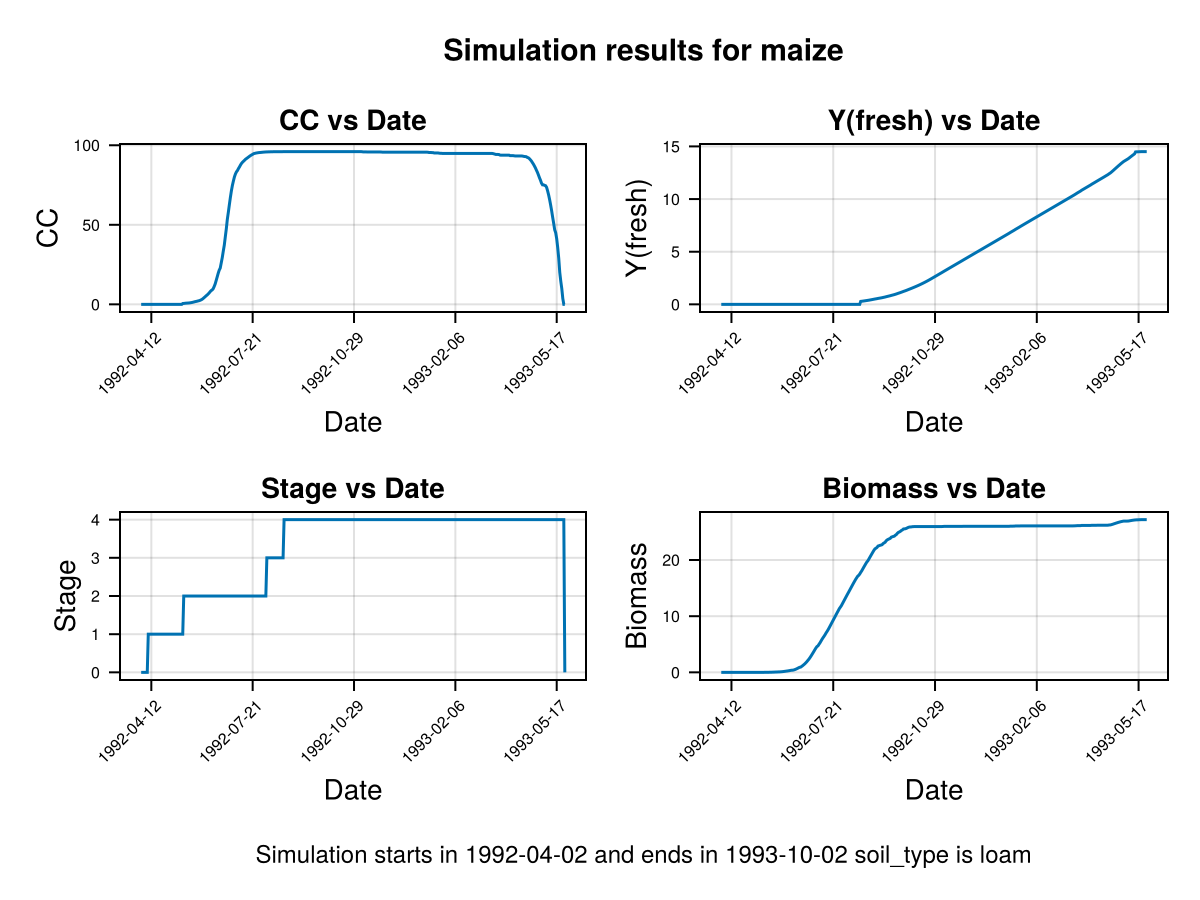

In [8]:
# plot the results
CropGrowthTutorial.plot_daily_stuff_one_year(cropfield, crop_type, soil_type)

we can pass information about some crop parameters using a dictionary like this:


SIMULATION WENT WELL

Data planting density 117000
Crop's planting density 117000



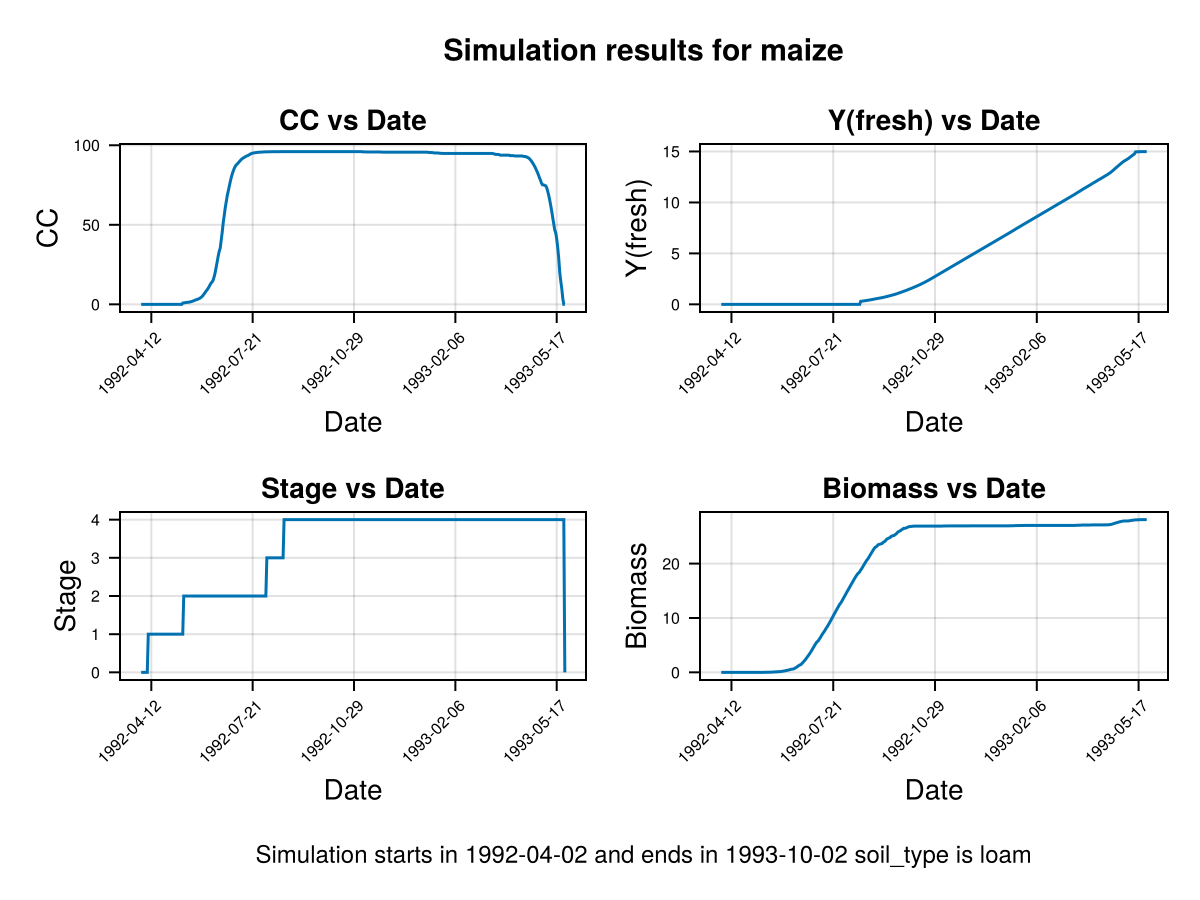

In [9]:
# get the planting density for the given crop_type
plantingdens = filter(row -> row.crop_type==crop_type, general_crop_data_df)[1,:plantingdens];

# create a kw tuple with the additional information that we wish to pass to AquaCrop
kw = (
        crop_dict = Dict("PlantingDens" => plantingdens),
     )

# run a simulation sending the additional kw
cropfield, all_ok = CropGrowthTutorial.run_simulation(soil_type, crop_name, sowing_date, uhk_clim_df; kw...);

# check if all is ok with the simulation
if all_ok.logi
    println("\nSIMULATION WENT WELL\n")
else
    println("\nBAD SIMULATION, error\n")
    println(all_ok.msg)
    println("")
end

println("Data planting density ", plantingdens)
println("Crop's planting density ", cropfield.crop.PlantingDens)
println("")

# plot the results
CropGrowthTutorial.plot_daily_stuff_one_year(cropfield, crop_type, soil_type)

## Crop Calibration

In `AquaCrop.jl` there are lot's of parameters that control the crop's growth, they need to be calibrated following the models causality.
For our specific case we will assume the following:
1. The climate data is complete.
1. The soil is well characterized.
1. We have field phenology, biomass and yield data, and was collected correctly.   

And follow these steps for the calibration:
1. Crop stages using phenology data.
1. Soil-root behaviour.
1. Canopy cover.
1. Biomass.
1. Yield.

### Crop Phenology Stages calibration

To do this we will use the phenology field data from CAP4GI, where we have dates of several crop phases. Some of these phases are related to AquaCrop's parameters, with these dates and the climate data we can find better values of the Growing Degree Days until each stage of the crop.

The minimal data for this is:
1. Phenology dates recorded from field.
1. Climate data.
1. Crop's minimal and maximal temperature of development.

In [10]:
# process phenology raw data phases
sowing_phase = 10; # sowing phase id
harvest_phase = 39; # harvest phase id for silage maize
maize_phenology_df = CropGrowthTutorial.process_crop_phenology(maize_phenology_raw_df, sowing_phase, harvest_phase)

Row,beginfloweringdate,daystoharvest,emergencedate,endfloweringdate,harvestdate,sowingdate,stations_id,year
,Date?,Int64,Date?,Date?,Date,Date,Int64,Int64
1,2015-07-17,124,2015-05-12,missing,2015-08-31,2015-04-29,15460,2015
2,2016-07-16,124,2016-05-13,missing,2016-08-31,2016-04-29,15460,2016
3,2017-07-13,124,2017-05-17,missing,2017-09-06,2017-05-05,15460,2017
4,2018-07-07,105,2018-05-10,missing,2018-08-10,2018-04-27,15460,2018
5,2019-07-17,114,2019-05-21,missing,2019-08-28,2019-05-06,15460,2019
6,2020-07-13,116,2020-05-19,missing,2020-08-29,2020-05-05,15460,2020
7,2021-07-22,122,2021-05-20,missing,2021-09-05,2021-05-06,15460,2021
8,2022-07-19,98,2022-05-16,missing,2022-08-15,2022-05-09,15460,2022


In [11]:
# get the days and growing degree days for each phenology phase from the actual data
maize_phenology_actual_df = CropGrowthTutorial.process_crop_phenology_actual_gdd(crop_name, maize_phenology_df, uhk_clim_df)

Row,sowingdate,harvestdate,harvest_actualdays,harvest_actualgdd,beginflowering_actualdays,beginflowering_actualgdd,endflowering_actualdays,endflowering_actualgdd,emergence_actualdays,emergence_actualgdd
,Date,Date,Int64?,Float64?,Int64?,Float64?,Int64?,Float64?,Int64?,Float64?
1,2015-04-29,2015-08-31,124,1142.2,79,604.7,missing,missing,13,68.75
2,2016-04-29,2016-08-31,124,1159.9,78,638.95,missing,missing,14,64.1
3,2017-05-05,2017-09-06,124,1211.9,69,648.1,missing,missing,12,64.75
4,2018-04-27,2018-08-10,105,1104.05,71,647.2,missing,missing,13,67.55
5,2019-05-06,2019-08-28,114,1113.4,72,599.0,missing,missing,15,43.8
6,2020-05-05,2020-08-29,116,1084.8,69,530.2,missing,missing,14,45.45
7,2021-05-06,2021-09-05,122,1140.4,77,702.95,missing,missing,14,73.6
8,2022-05-09,2022-08-15,98,1026.85,71,688.4,missing,missing,7,61.15


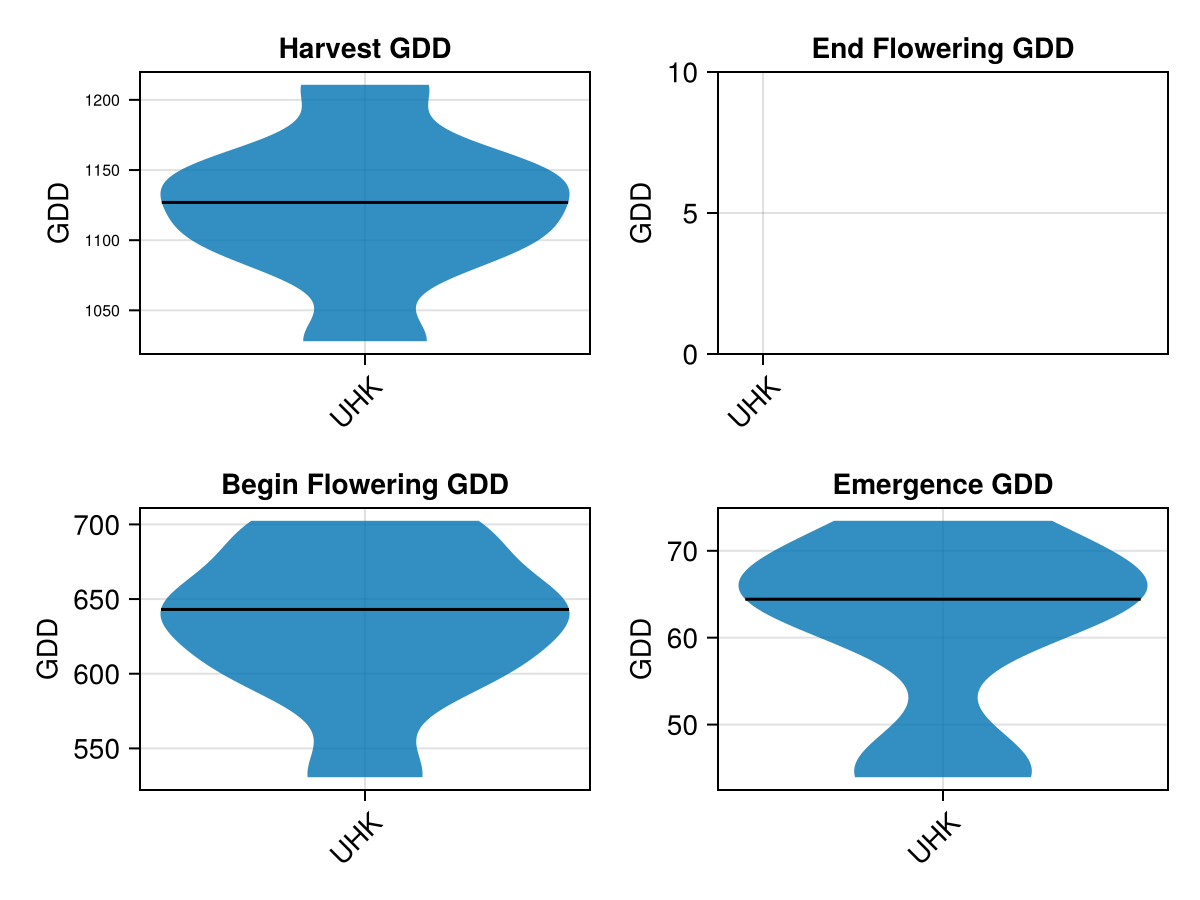

In [12]:
# plot the distribution of gddays until the phenology phase from the actual data
CropGrowthTutorial.plot_GDD_stats_violin(maize_phenology_actual_df, "UHK")

In [13]:
# get the days and growing degree days for each phenology phase from the simulated data
maize_phenology_simulated_df = CropGrowthTutorial.process_crop_phenology_simulated_gdd(crop_name, maize_phenology_df, uhk_clim_df)

Row,sowingdate,harvest_simulateddays,harvest_simulatedgdd,beginflowering_simulateddays,beginflowering_simulatedgdd,endflowering_simulateddays,endflowering_simulatedgdd,emergence_simulateddays,emergence_simulatedgdd
,Date,Int64?,Float64?,Int64?,Float64?,Int64?,Float64?,Int64?,Float64?
1,2015-04-29,400,1694.95,102,883.65,117,1060.15,16,80.8
2,2016-04-29,391,1702.3,97,877.35,116,1063.7,20,80.25
3,2017-05-05,371,1699.4,89,874.25,106,1057.5,13,77.35
4,2018-04-27,357,1700.3,90,878.6,102,1059.6,15,83.9
5,2019-05-06,388,1701.35,94,882.0,110,1055.15,21,77.5
6,2020-05-05,398,1699.15,99,875.75,114,1064.4,20,78.55
7,2021-05-06,394,1698.65,93,878.7,112,1063.3,15,81.25
8,2022-05-09,364,1700.95,86,879.7,100,1055.55,9,84.0


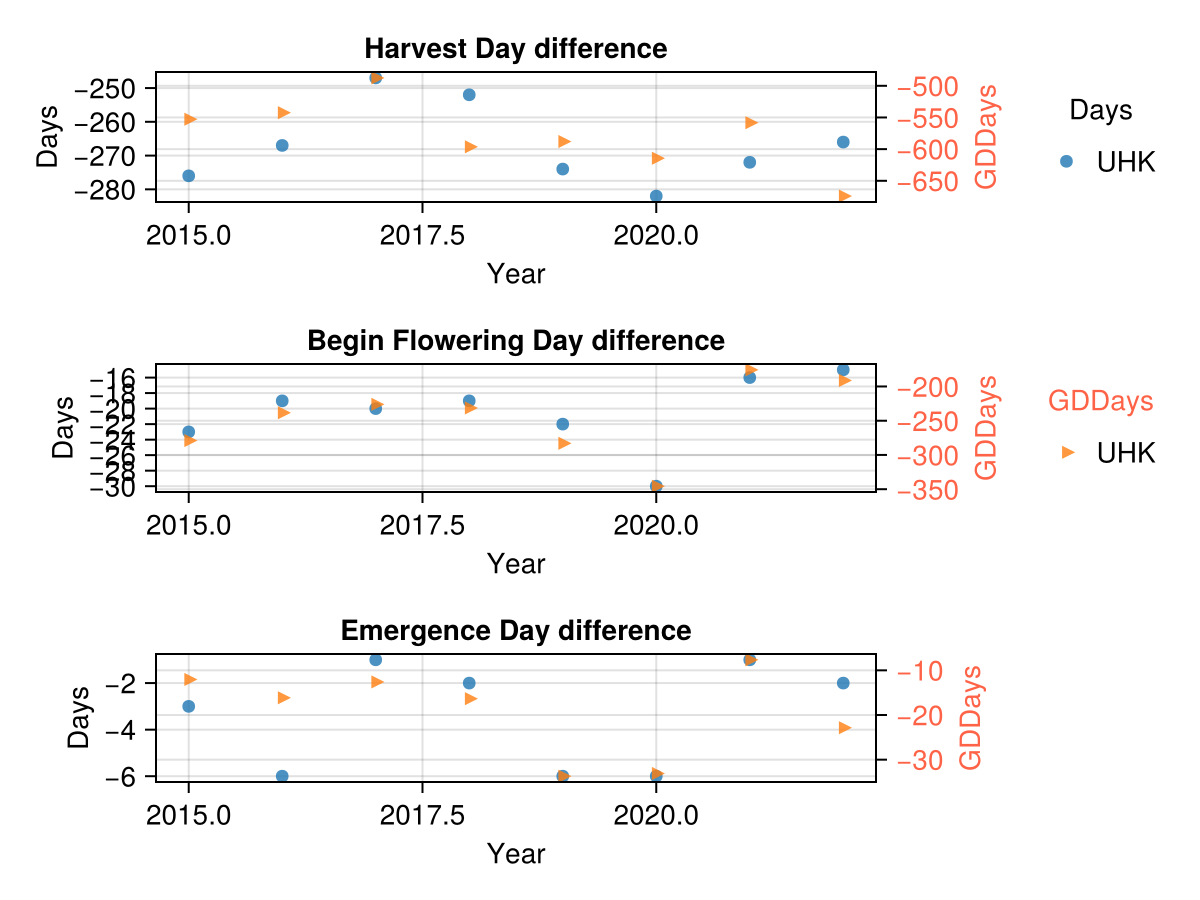

In [14]:
# compare the day difference between the actual data and the simulated data
maize_phenology_df = leftjoin(maize_phenology_actual_df, maize_phenology_simulated_df; on=:sowingdate);
CropGrowthTutorial.plot_GDD_stats_years(maize_phenology_df, "UHK")

In the last figure we use the default AquaCrop parameters for the phenology phases. We see that the actual phase happens long before the simulated phase, specially for harvest.

In [15]:
# get a statistical distribution of the actual gdd data
describe(maize_phenology_actual_df)

Row,variable,mean,min,median,max,nmissing,eltype
,Symbol,Union…,Any,Any,Any,Int64,Type
1,sowingdate,,2015-04-29,2018-10-31,2022-05-09,0,Date
2,harvestdate,,2015-08-31,,2022-08-15,0,Date
3,harvest_actualdays,115.875,98,119.0,124,0,"Union{Missing, Int64}"
4,harvest_actualgdd,1122.94,1026.85,1126.9,1211.9,0,"Union{Missing, Float64}"
5,beginflowering_actualdays,73.25,69,71.5,79,0,"Union{Missing, Int64}"
6,beginflowering_actualgdd,632.438,530.2,643.075,702.95,0,"Union{Missing, Float64}"
7,endflowering_actualdays,NaN,,,,8,"Union{Missing, Int64}"
8,endflowering_actualgdd,NaN,,,,8,"Union{Missing, Float64}"
9,emergence_actualdays,12.75,7,13.5,15,0,"Union{Missing, Int64}"


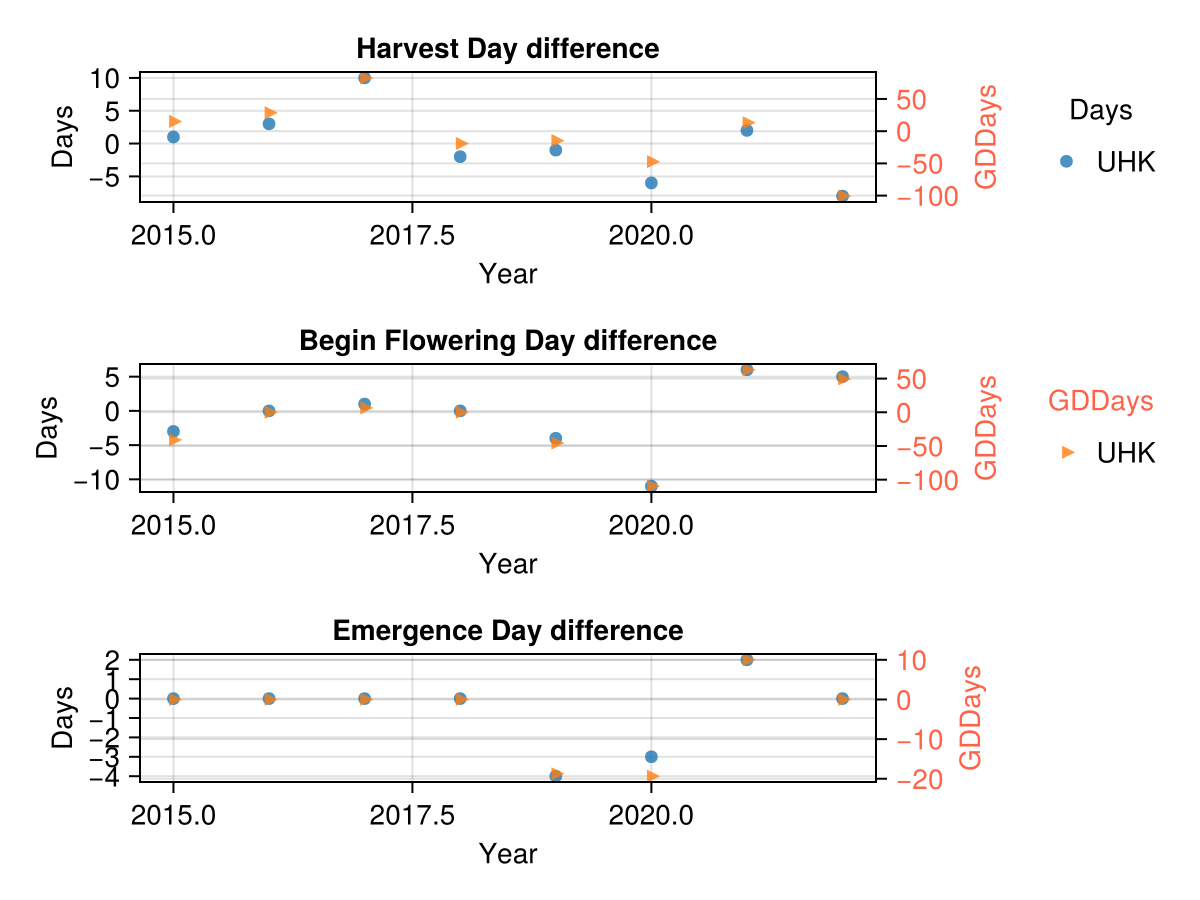

In [16]:
# create a kw tuple with the additional information that we wish to pass to AquaCrop
# consider the median of the actual gdd distribution for each phenology phase
kw = (
        crop_dict = Dict(
            "PlantingDens" => plantingdens,
            "GDDaysToHarvest" => 1127, # harvest
            "GDDaysToFlowering" => 643, # beginflowering
            "GDDaysToGermination" => 64, # emergence
            "GDDLengthFlowering" => 180 # default value of aquacrop since we do not have endflowering
        ),
     );

# get the days and growing degree days for each phenology phase from the simulated data using the additional information
maize_phenology_simulated_df = CropGrowthTutorial.process_crop_phenology_simulated_gdd(crop_name, maize_phenology_df, uhk_clim_df; kw...)

# compare the day difference between the actual data and the simulated data
maize_phenology_df = leftjoin(maize_phenology_actual_df, maize_phenology_simulated_df; on=:sowingdate);
CropGrowthTutorial.plot_GDD_stats_years(maize_phenology_df, "UHK")

In the last figure we use the calibrated parameters for the phenology phases. We see that the actual phase and the simulated phase are not far away.

1. plot correlation between harves_actual and harvest_simulated
1. show autamatization of all this with shk station, (`crop_dict, df = phenology_fit(median_heuristic(), climate_df, phenology_df, soil_type, crop_name; kw...)`  also have a `default_heuristic()` that uses AquaCrop default parameters)
